### DEEP LEARNING

# Imports


In [ ]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, regularizers,models 

import itertools

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Deeplearning

## Labels view


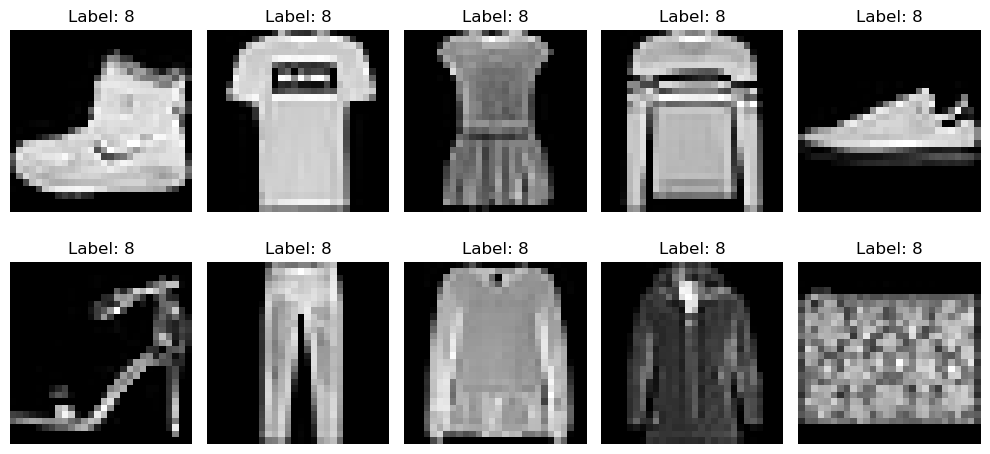

In [32]:
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)


seen = set() ## For one image per Class
images = []

for img, label in train_dataset:
    if label not in seen:
        images.append((img, label))
        seen.add(label)
    if len(seen) == 10:   # After collecting all the classes
        break

fig, axs = plt.subplots(2, 5, figsize=(10, 5))

for i, (img, labell) in enumerate(images):
    r = i // 5
    c = i % 5
    axs[r, c].imshow(img.squeeze().numpy(), cmap='gray')
    axs[r, c].set_title(f"Label: {label}")
    axs[r, c].axis("off")

plt.tight_layout()
plt.show()


## FeedForward Implementation

In [17]:
def build_ffnn(hidden_layers=[128, 64], activation='relu', weight_decay=0.0):
    """
    Here it is intialized with two hidden layers one with 128 and second with 64 if we wanted to change we just change these list 
    for example if i want three hidden layers = [256,128,64]
    Note : it is preferred for better accuracy to use numbers resulting from 2^n 
    """ 
    model = models.Sequential()
    
    # Input layer 
    model.add(layers.Flatten(input_shape=(28, 28)))
    # Define Regularizer

    if weight_decay > 0:
        reg = regularizers.l2(weight_decay)
    else:
        reg = None
        
    for units in hidden_layers:
        model.add(layers.Dense(units, activation=activation))
    
    # Output layer — 10 classes
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

model = build_ffnn(hidden_layers=[128, 64])

train_x = train_dataset.data.numpy() / 255.0
train_y = train_dataset.targets.numpy()

sample_x = train_x[:5]  # take first 5 images
predictions = model(sample_x)
print("Forward propagation outputs (probabilities):\n", predictions.numpy())


Forward propagation outputs (probabilities):
 [[0.05303311 0.02994685 0.18522622 0.10464195 0.12065959 0.1094344
  0.03620783 0.12684071 0.16959582 0.06441348]
 [0.03226205 0.06943087 0.09039477 0.1061568  0.10000189 0.19112581
  0.11582181 0.09903145 0.12695673 0.06881779]
 [0.08844998 0.08607477 0.09255122 0.11825547 0.10333564 0.13298427
  0.09785078 0.09142209 0.10322682 0.0858489 ]
 [0.07514487 0.09054535 0.11510973 0.10630262 0.08981142 0.145792
  0.09219328 0.07998312 0.12054322 0.08457438]
 [0.07789984 0.07907829 0.08459755 0.09209919 0.11584289 0.16254446
  0.09066717 0.09129178 0.13563621 0.07034262]]


c:\Users\Fares\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data')
test_dataset = torchvision.datasets.FashionMNIST(root='./data')


train_x = train_dataset.data.numpy() / 255.0
train_y = train_dataset.targets.numpy()
test_x = test_dataset.data.numpy() / 255.0
test_y = test_dataset.targets.numpy()

test_x, val_x, test_y, val_y = train_test_split(test_x, test_y, test_size=0.2, random_state=42)


## Backword Propagation

In [36]:
def backward_prop(epochs, num_layers, size, wdecay, learning_rate, optimizer, batch_size, act):
    
    current_hidden_layers = [size] * num_layers

    
    model = build_ffnn(hidden_layers=current_hidden_layers, activation=act, weight_decay=wdecay)

    if optimizer == 'sgd':
        optimizer_type = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'sgd_momentum':
        optimizer_type = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer == 'nesterov':
        optimizer_type = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer == 'rmsprop':
        optimizer_type = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer_type = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
    optimizer=optimizer_type,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )
    history = model.fit(
        train_x, train_y, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(val_x, val_y), 
        verbose=0
    )
    return history.history['val_accuracy'][-1], model


In [47]:
# Hyperparameters from your message
epochs_options = [5,10]                        # Full: [5, 10]
layers_count_options = [5]                     # Full: [3, 4, 5]
layer_size_options = [64,128]                      # Full: [32, 64, 128]
weight_decay_options = [0]                     # Full: [0, 0.0005, 0.5]
lr_options = [0.001]                           # Full: [1e-3, 1e-4]
optimizer_options = ['adam']                   # Full: ['sgd', 'sgd_momentum', 'nesterov', 'rmsprop', 'adam']
batch_size_options = [32,64]                      # Full: [16, 32, 64]
activation_options = ['relu',"tanh"]           # Full: ['sigmoid', 'tanh', 'relu']

# Generate all combinations
combinations = list(itertools.product(
    epochs_options, layers_count_options, layer_size_options, weight_decay_options,
    lr_options, optimizer_options, batch_size_options, activation_options
))

best_acc = 0.0
best_model = None
best_params = {}

for i, (epochs, num_layers, size, wdecay, lrate, opt_name, bs, act) in enumerate(combinations):
    
    print(f"Testing {i+1}/{len(combinations)}: Ep={epochs}, Lay={num_layers}, Size={size}, Opt={opt_name}, Act={act}")
    
    val_acc, trained_model = backward_prop(epochs, num_layers, size, wdecay, learning_rate=lrate, optimizer=opt_name, batch_size=bs, act=act)
    
    print(f" Val Acc: {val_acc:.4f}")

    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = trained_model
        best_params = (epochs, num_layers, size, wdecay, lrate, opt_name, bs, act)

print(f"\nBest Accuracy on validation data: {best_acc}")
print(f"Best Params: {best_params}")
    
test_loss, test_acc = best_model.evaluate(test_x, test_y)
print(f"Final Test Accuracy: {test_acc}")

Testing 1/16: Ep=5, Lay=5, Size=64, Opt=adam, Act=relu
 Val Acc: 0.8802
Testing 2/16: Ep=5, Lay=5, Size=64, Opt=adam, Act=tanh
 Val Acc: 0.8827
Testing 3/16: Ep=5, Lay=5, Size=64, Opt=adam, Act=relu
 Val Acc: 0.8872
Testing 4/16: Ep=5, Lay=5, Size=64, Opt=adam, Act=tanh
 Val Acc: 0.8875
Testing 5/16: Ep=5, Lay=5, Size=128, Opt=adam, Act=relu
 Val Acc: 0.8915
Testing 6/16: Ep=5, Lay=5, Size=128, Opt=adam, Act=tanh
 Val Acc: 0.8717
Testing 7/16: Ep=5, Lay=5, Size=128, Opt=adam, Act=relu
 Val Acc: 0.8913
Testing 8/16: Ep=5, Lay=5, Size=128, Opt=adam, Act=tanh
 Val Acc: 0.8917
Testing 9/16: Ep=10, Lay=5, Size=64, Opt=adam, Act=relu
 Val Acc: 0.8934
Testing 10/16: Ep=10, Lay=5, Size=64, Opt=adam, Act=tanh
 Val Acc: 0.8984
Testing 11/16: Ep=10, Lay=5, Size=64, Opt=adam, Act=relu
 Val Acc: 0.9015
Testing 12/16: Ep=10, Lay=5, Size=64, Opt=adam, Act=tanh
 Val Acc: 0.8977
Testing 13/16: Ep=10, Lay=5, Size=128, Opt=adam, Act=relu
 Val Acc: 0.9088
Testing 14/16: Ep=10, Lay=5, Size=128, Opt=adam, A

# Q5: Model Regularization and Optimization

New FFNN AND Backprop

In [48]:
def ffnn(hidden_layers=[128, 64], activation='relu', weight_decay=0.0, dropout_rate=0.0, use_batch_norm=False):
    model = models.Sequential()
    
    # Input layer 
    model.add(layers.Flatten(input_shape=(28, 28)))
    
    # Define Regularizer (L2)
    if weight_decay > 0:
        reg = regularizers.l2(weight_decay)
    else:
        reg = None
        
    for units in hidden_layers:
        # 1. Add Dense Layer
        model.add(layers.Dense(units, kernel_regularizer=reg))
        
        if use_batch_norm:
            model.add(layers.BatchNormalization())
            

        model.add(layers.Activation(activation))
        
        
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    
    # Output layer — 10 classes
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

In [49]:
def backward_prop(epochs, num_layers, size, wdecay, learning_rate, optimizer, batch_size, act, dropout_rate, use_batch_norm):
    
    current_hidden_layers = [size] * num_layers
    
    
    model =ffnn(hidden_layers=current_hidden_layers, activation=act, 
                       weight_decay=wdecay,dropout_rate=dropout_rate,
                       use_batch_norm=use_batch_norm)

    if optimizer == 'sgd':
        optimizer_type = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'sgd_momentum':
        optimizer_type = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer == 'nesterov':
        optimizer_type = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer == 'rmsprop':
        optimizer_type = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adam':
        optimizer_type = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer_type,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_x, train_y, 
        batch_size=batch_size, 
        epochs=epochs, 
        validation_data=(val_x, val_y), 
        verbose=0
    )
    return history.history['val_accuracy'][-1], model

In [51]:

epochs_options = [10]
layers_count_options = [5]
layer_size_options = [64]
weight_decay_options = [0]  
lr_options = [0.001]
optimizer_options = ['adam']
batch_size_options = [64]
activation_options = ['relu']
dropout_options = [0.0,0.1, 0.2]       
batch_norm_options = [False, True] 

# Generate all combinations
combinations = list(itertools.product(
    epochs_options, layers_count_options, layer_size_options, weight_decay_options,
    lr_options, optimizer_options, batch_size_options, activation_options,
    dropout_options, batch_norm_options
))

print(f"Total combinations to test: {len(combinations)}")

best_acc = 0.0
best_model = None
best_params = {}

for i, (ep, num_layers, size, wdecay, lrate, opt_name, bs, act, drop, bnorm) in enumerate(combinations):
    
    print(f"Testing {i+1}: Drop={drop}, BN={bnorm}, LR={lrate}")
    
    val_acc, trained_model = backward_prop(ep, num_layers, size, wdecay, lrate, opt_name, bs, act, drop, bnorm)
    
    print(f" Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model = trained_model
        best_params = (ep, num_layers, size, wdecay, lrate, opt_name, bs, act, drop, bnorm)

print(f"\nBest Validation Accuracy: {best_acc}")
print(f"Best Parameters: {best_params}")

test_loss, test_acc = best_model.evaluate(test_x, test_y)
print(f"Final Test Accuracy: {test_acc}")

Total combinations to test: 6
Testing 1: Drop=0.0, BN=False, LR=0.001
 Val Acc: 0.9029
Testing 2: Drop=0.0, BN=True, LR=0.001
 Val Acc: 0.8843
Testing 3: Drop=0.1, BN=False, LR=0.001
 Val Acc: 0.8962
Testing 4: Drop=0.1, BN=True, LR=0.001
 Val Acc: 0.8974
Testing 5: Drop=0.2, BN=False, LR=0.001
 Val Acc: 0.8814
Testing 6: Drop=0.2, BN=True, LR=0.001
 Val Acc: 0.8884

Best Validation Accuracy: 0.902916669845581
Best Parameters: (10, 5, 64, 0, 0.001, 'adam', 64, 'relu', 0.0, False)
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - accuracy: 0.9024 - loss: 0.2566
Final Test Accuracy: 0.9024166464805603


MODEL EVALUATION
Best Hyperparameters Found: (10, 5, 64, 0, 0.001, 'adam', 64, 'relu', 0.0, False)
Accuracy on Test Set: 0.9024 (90.24%)
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step


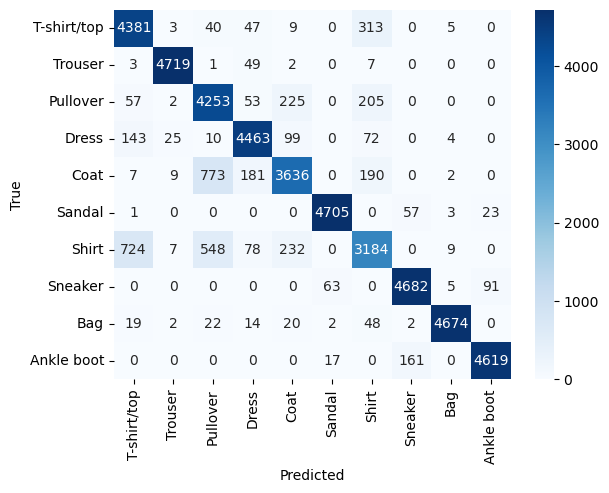

In [52]:
print("MODEL EVALUATION")

print(f"Best Hyperparameters Found: {best_params}")

test_loss, test_acc = best_model.evaluate(test_x, test_y, verbose=0)
print(f"Accuracy on Test Set: {test_acc:.4f} ({test_acc*100:.2f}%)")

test_predictions_prob = best_model.predict(test_x)
test_predictions = np.argmax(test_predictions_prob, axis=1)

cm = confusion_matrix(test_y, test_predictions)

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Conclusion 
 - it is clear that by tunning the parameters that The Adam optimizer is the best one showing results 
 - it is nice to increase Epochs numbers so that model can learn more and more but dont increase it too much as not to overfit 
 - The Activation function Relu shows the best Results for these Type of data (Classification)
 - The lower the Learning rate the better the model learn as it learn the details 
 - If we experienced in the data (Not here) overfitting problem using drop out could resolve these problem